In [5]:
# Install albumentations with --user flag to avoid permission issues
import sys
!{sys.executable} -m pip install --user albumentations

  Using cached albumentations-2.0.8-py3-none-any.whl.metadata (43 kB)
  Using cached albucore-0.0.24-py3-none-any.whl.metadata (5.3 kB)
  Using cached opencv_python_headless-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached albumentations-2.0.8-py3-none-any.whl (369 kB)
Using cached albucore-0.0.24-py3-none-any.whl (15 kB)
Using cached opencv_python_headless-4.12.0.88-cp37-abi3-win_amd64.whl (38.9 MB)

   ---------------------------------------- 0/3 [opencv-python-headless]
   ---------------------------------------- 0/3 [opencv-python-headless]
   ---------------------------------------- 0/3 [opencv-python-headless]
   ---------------------------------------- 0/3 [opencv-python-headless]
   -------------------------- ------------- 2/3 [albumentations]
   -------------------------- ------------- 2/3 [albumentations]
   -------------------------- ------------- 2/3 [albumentations]
   ---------------------------------------- 3/3 [albumentations]



Annotation info:
Image size: {'height': 2909, 'width': 1642}
Number of objects: 1
Decompressed data length: 3103
Origin: [421, 474]
Bitmap shape: (1388, 712)
Bitmap unique values: [  0 255]

Final mask shape: (2909, 1642)
Final mask unique values: [  0 255]
Non-zero pixels: 637924


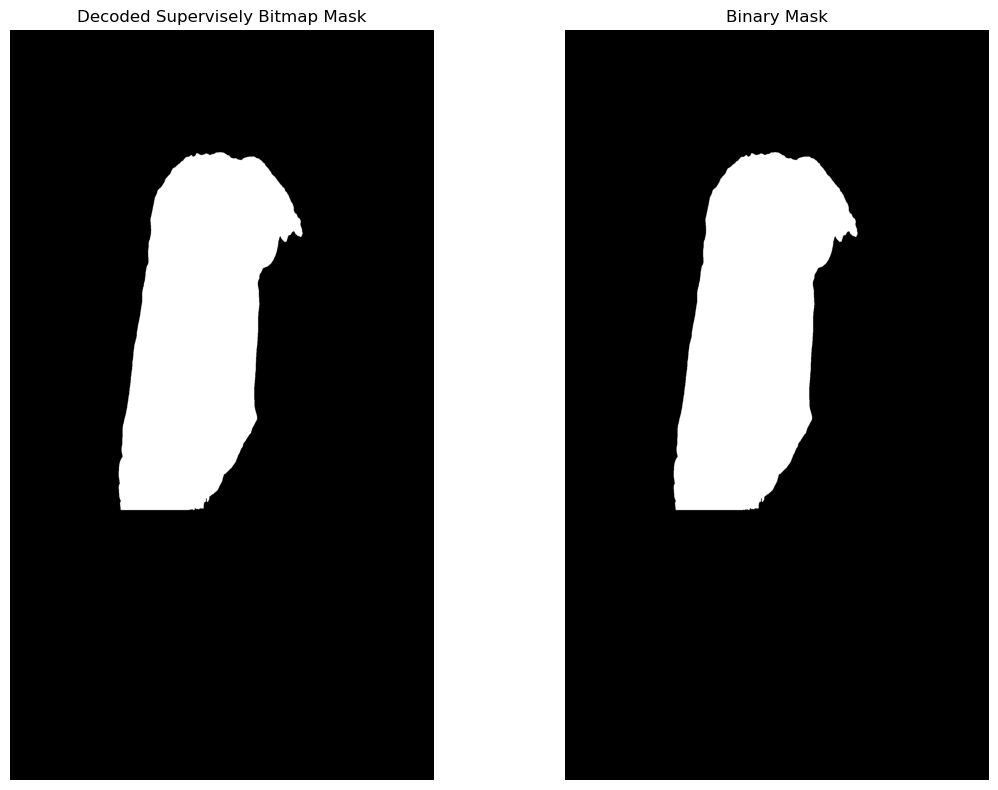

In [6]:
import json
import base64
import zlib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import io

def decode_supervisely_bitmap_proper(annotation_data):
    """
    Properly decode Supervisely bitmap mask from annotation data
    Supervisely stores bitmap data as compressed PNG-like format
    """
    img_height = annotation_data['size']['height']
    img_width = annotation_data['size']['width']
    
    # Create empty mask
    full_mask = np.zeros((img_height, img_width), dtype=np.uint8)
    
    for obj in annotation_data.get('objects', []):
        if obj.get('geometryType') == 'bitmap' and 'bitmap' in obj:
            bitmap_data = obj['bitmap']
            
            # Get the encoded bitmap data and origin
            encoded_data = bitmap_data['data']
            origin = bitmap_data['origin']  # [x, y] coordinates
            
            try:
                # Decode base64 and decompress
                compressed_data = base64.b64decode(encoded_data)
                decompressed_data = zlib.decompress(compressed_data)
                
                print(f"Decompressed data length: {len(decompressed_data)}")
                print(f"Origin: {origin}")
                
                # Supervisely bitmap data is typically stored as PNG-like format
                # Try to decode as image data first
                try:
                    # Try to load as image bytes
                    img_bytes = io.BytesIO(decompressed_data)
                    bitmap_img = Image.open(img_bytes)
                    bitmap_array = np.array(bitmap_img)
                    
                    # Convert to binary mask if needed
                    if len(bitmap_array.shape) > 2:
                        # Convert to grayscale if RGB
                        bitmap_array = np.mean(bitmap_array, axis=2)
                    
                    # Normalize to 0-255
                    bitmap_array = (bitmap_array > 0).astype(np.uint8) * 255
                    
                except:
                    # If that fails, try other decoding methods
                    # Supervisely sometimes stores data as raw bytes with width/height info
                    
                    # Try to find dimensions from the remaining space
                    remaining_width = img_width - origin[0]
                    remaining_height = img_height - origin[1]
                    
                    # Check if it's a simple bitmap (1 bit per pixel, packed)
                    expected_bits = remaining_width * remaining_height
                    expected_bytes = (expected_bits + 7) // 8  # Round up to nearest byte
                    
                    if len(decompressed_data) == expected_bytes:
                        # Unpack bits
                        bits = np.unpackbits(np.frombuffer(decompressed_data, dtype=np.uint8))
                        bitmap_array = bits[:expected_bits].reshape((remaining_height, remaining_width)) * 255
                    else:
                        # Try interpreting as bytes directly
                        mask_1d = np.frombuffer(decompressed_data, dtype=np.uint8)
                        
                        # Find best fitting dimensions
                        possible_dims = []
                        for w in range(1, min(remaining_width + 1, len(mask_1d) + 1)):
                            if len(mask_1d) % w == 0:
                                h = len(mask_1d) // w
                                if h <= remaining_height and w <= remaining_width:
                                    possible_dims.append((h, w))
                        
                        if possible_dims:
                            # Choose the most square-like dimensions
                            h, w = min(possible_dims, key=lambda x: abs(x[0] - x[1]))
                            bitmap_array = mask_1d.reshape((h, w))
                            # Threshold to binary
                            bitmap_array = (bitmap_array > 0).astype(np.uint8) * 255
                        else:
                            print(f"Could not determine bitmap dimensions")
                            continue
                
                print(f"Bitmap shape: {bitmap_array.shape}")
                print(f"Bitmap unique values: {np.unique(bitmap_array)}")
                
                # Place the bitmap in the full mask
                end_y = min(origin[1] + bitmap_array.shape[0], img_height)
                end_x = min(origin[0] + bitmap_array.shape[1], img_width)
                
                actual_h = end_y - origin[1]
                actual_w = end_x - origin[0]
                
                # Resize bitmap if necessary
                if bitmap_array.shape != (actual_h, actual_w):
                    bitmap_pil = Image.fromarray(bitmap_array)
                    bitmap_pil = bitmap_pil.resize((actual_w, actual_h), Image.NEAREST)
                    bitmap_array = np.array(bitmap_pil)
                
                full_mask[origin[1]:end_y, origin[0]:end_x] = bitmap_array
                
            except Exception as e:
                print(f"Error decoding bitmap: {e}")
                import traceback
                traceback.print_exc()
                continue
    
    return full_mask

# Load and decode the annotation
json_path = r"supervisely/dataset/ann/blackpig1crop.jpg.json"
with open(json_path, 'r') as f:
    annotation_data = json.load(f)

print("Annotation info:")
print(f"Image size: {annotation_data['size']}")
print(f"Number of objects: {len(annotation_data.get('objects', []))}")

# Decode the bitmap mask
mask = decode_supervisely_bitmap_proper(annotation_data)

print(f"\nFinal mask shape: {mask.shape}")
print(f"Final mask unique values: {np.unique(mask)}")
print(f"Non-zero pixels: {np.sum(mask > 0)}")

# Visualize the mask
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='gray')
plt.title('Decoded Supervisely Bitmap Mask')
plt.axis('off')

# Show mask as binary
plt.subplot(1, 2, 2)
binary_mask = (mask > 0).astype(np.uint8)
plt.imshow(binary_mask, cmap='gray')
plt.title('Binary Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
import os
import json
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def simple_augmentations(image, mask):
    """
    Simple augmentations using only OpenCV and NumPy
    """
    augmented_pairs = []
    
    # Original
    augmented_pairs.append((image.copy(), mask.copy()))
    
    # Horizontal flip
    img_flip = cv2.flip(image, 1)
    mask_flip = cv2.flip(mask, 1)
    augmented_pairs.append((img_flip, mask_flip))
    
    # Rotation 15 degrees
    h, w = image.shape[:2]
    center = (w//2, h//2)
    M = cv2.getRotationMatrix2D(center, 15, 1.0)
    img_rot = cv2.warpAffine(image, M, (w, h))
    mask_rot = cv2.warpAffine(mask, M, (w, h))
    augmented_pairs.append((img_rot, mask_rot))
    
    # Brightness adjustment
    img_bright = cv2.convertScaleAbs(image, alpha=1.2, beta=20)
    augmented_pairs.append((img_bright, mask.copy()))
    
    # Gaussian noise
    noise = np.random.normal(0, 25, image.shape).astype(np.uint8)
    img_noise = cv2.add(image, noise)
    augmented_pairs.append((img_noise, mask.copy()))
    
    return augmented_pairs

def create_augmented_dataset_simple(dataset_path, output_path, num_augmentations=5):
    """
    Apply simple data augmentation without albumentations
    """
    img_dir = os.path.join(dataset_path, "img")
    ann_dir = os.path.join(dataset_path, "ann")
    
    # Debug: Check what files actually exist
    print(f"Checking directories:")
    print(f"Image directory: {img_dir}")
    print(f"Annotation directory: {ann_dir}")
    
    if os.path.exists(img_dir):
        img_files = os.listdir(img_dir)
        print(f"Image files found: {img_files}")
    else:
        print(f"Image directory does not exist: {img_dir}")
        return
    
    if os.path.exists(ann_dir):
        ann_files = os.listdir(ann_dir)
        print(f"Annotation files found: {ann_files}")
    else:
        print(f"Annotation directory does not exist: {ann_dir}")
        return
    
    # Create output directories
    output_img_dir = os.path.join(output_path, "img")
    output_ann_dir = os.path.join(output_path, "ann")
    output_mask_dir = os.path.join(output_path, "masks")
    
    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_ann_dir, exist_ok=True)
    os.makedirs(output_mask_dir, exist_ok=True)
    
    # Create a mapping of available image files (without extensions)
    available_images = {}
    for img_file in os.listdir(img_dir):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
            # Get base name without extension
            base_name = os.path.splitext(img_file)[0]
            available_images[base_name] = img_file
    
    print(f"Available image base names: {list(available_images.keys())}")
    
    # Process each annotation file
    processed_count = 0
    for json_file in os.listdir(ann_dir):
        if not json_file.endswith('.json'):
            continue
            
        # Get base name from JSON file (remove .json extension)
        base_name = json_file.replace('.json', '')
        print(f"Looking for image matching: '{base_name}'")
        
        # Look for exact match first
        img_file = available_images.get(base_name)
        
        # If no exact match, try fuzzy matching
        if img_file is None:
            # Try removing common suffixes that might be added to JSON files
            for suffix in ['.jpg', '.jpeg', '.png']:
                if base_name.endswith(suffix):
                    clean_base = base_name[:-len(suffix)]
                    img_file = available_images.get(clean_base)
                    if img_file:
                        break
        
        if img_file is None:
            print(f"No corresponding image found for {json_file}")
            print(f"  Tried base name: '{base_name}'")
            continue
            
        print(f"Processing: {img_file} with {json_file}")
        
        # Load image and annotation
        img_path = os.path.join(img_dir, img_file)
        json_path = os.path.join(ann_dir, json_file)
        
        try:
            # Load image
            image = cv2.imread(img_path)
            if image is None:
                print(f"Failed to load image: {img_path}")
                continue
                
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Load and decode mask
            with open(json_path, 'r') as f:
                annotation_data = json.load(f)
            
            mask = decode_supervisely_bitmap_proper(annotation_data)
            mask_binary = (mask > 0).astype(np.uint8)
            
            # Generate augmentations
            augmented_pairs = simple_augmentations(image, mask_binary)
            
            # Save augmented versions
            for i, (aug_image, aug_mask) in enumerate(augmented_pairs[:num_augmentations + 1]):
                if i == 0:
                    # Original
                    prefix = "original"
                else:
                    # Augmented
                    prefix = f"aug_{i-1}"
                
                # Save image
                img_name = f"{prefix}_{img_file}"
                cv2.imwrite(os.path.join(output_img_dir, img_name), 
                           cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))
                
                # Save mask
                mask_name = f"{prefix}_{os.path.splitext(base_name)[0]}_mask.png"
                cv2.imwrite(os.path.join(output_mask_dir, mask_name), 
                           aug_mask * 255)
                
                # Save annotation for original only
                if i == 0:
                    ann_name = f"{prefix}_{json_file}"
                    with open(os.path.join(output_ann_dir, ann_name), 'w') as f:
                        json.dump(annotation_data, f)
                
                print(f"  Generated {prefix}")
            
            processed_count += 1
                
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    print(f"Successfully processed {processed_count} image-annotation pairs")
    print(f"Augmented dataset created in: {output_path}")

# Use the simple version
dataset_path = "supervisely/dataset"
output_path = "supervisely/augmented_dataset"

create_augmented_dataset_simple(dataset_path, output_path, num_augmentations=4)

Checking directories:
Image directory: supervisely/dataset\img
Annotation directory: supervisely/dataset\ann
Image files found: ['2246b75a-6673-45b7-8d50-fc68a1daba20.png', '3.jpg', '43777abf-3373-4d53-80b2-ddcd06745714.png', 'blackpig1.png', 'blackpig1crop.jpg', 'IMG_0366.jpeg', 'Whisk_734708d8200b1c59ad1499cfd5218a85dr.jpeg']
Annotation files found: ['2246b75a-6673-45b7-8d50-fc68a1daba20.png.json', '3.jpg.json', '43777abf-3373-4d53-80b2-ddcd06745714.png.json', 'blackpig1.png.json', 'blackpig1crop.jpg.json', 'IMG_0366.jpeg.json', 'Whisk_734708d8200b1c59ad1499cfd5218a85dr.jpeg.json']
Available image base names: ['2246b75a-6673-45b7-8d50-fc68a1daba20', '3', '43777abf-3373-4d53-80b2-ddcd06745714', 'blackpig1', 'blackpig1crop', 'IMG_0366', 'Whisk_734708d8200b1c59ad1499cfd5218a85dr']
Looking for image matching: '2246b75a-6673-45b7-8d50-fc68a1daba20.png'
Processing: 2246b75a-6673-45b7-8d50-fc68a1daba20.png with 2246b75a-6673-45b7-8d50-fc68a1daba20.png.json
Decompressed data length: 4922
Ori

Image size: (1642, 2909)
Mask shape: (2909, 1642)
Masked image saved as: masked_pig_supervisely.png


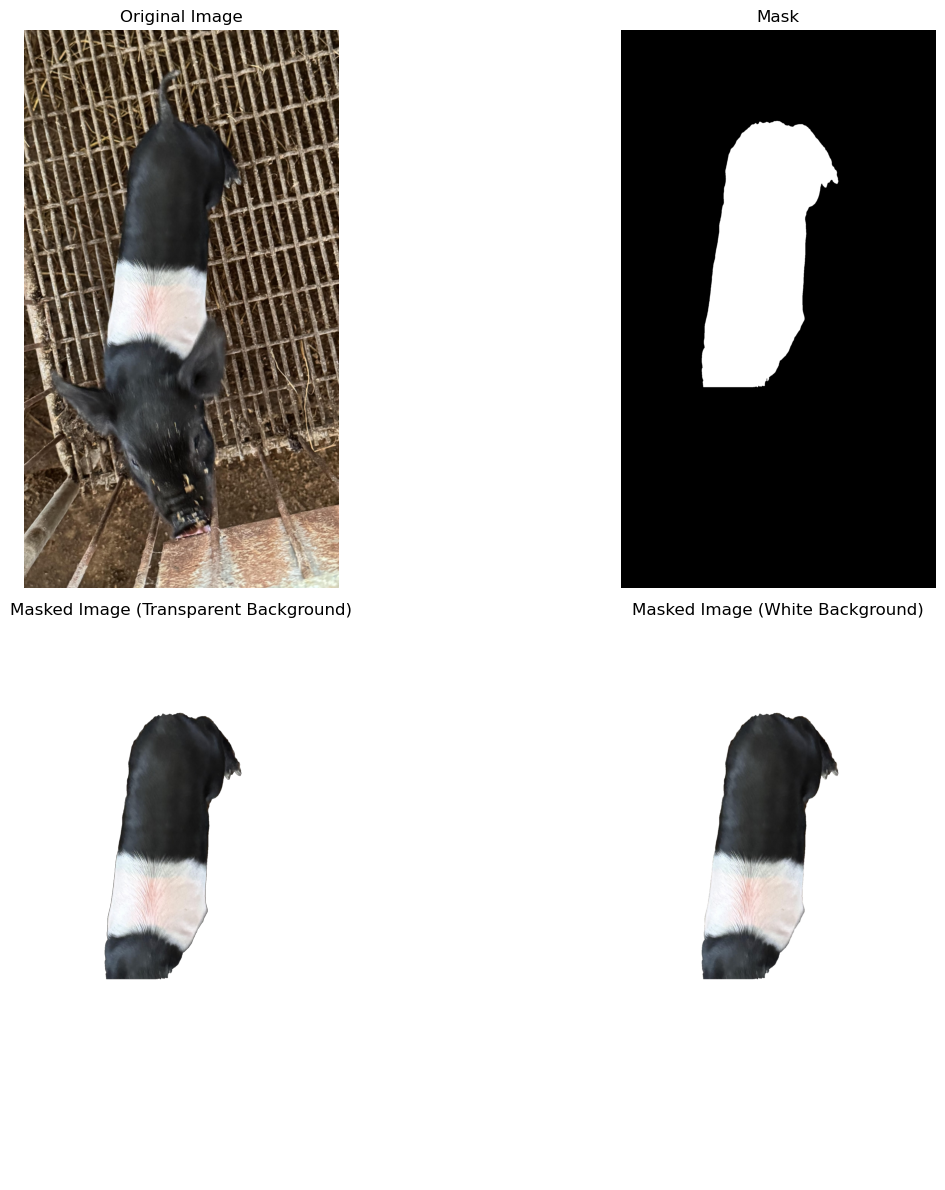

Also saved version with white background as: masked_pig_supervisely_white_bg.jpg


In [7]:
# Apply the mask to the original image
from PIL import Image
import matplotlib.pyplot as plt

# Load the original image
image_path = r"supervisely/dataset/img/blackpig1crop.jpg"
image = Image.open(image_path).convert("RGBA")

print(f"Image size: {image.size}")
print(f"Mask shape: {mask.shape}")

# Convert mask to PIL Image
mask_pil = Image.fromarray(mask, mode='L')

# Resize mask if needed to match image size
if mask_pil.size != image.size:
    # The mask is typically larger, so we need to resize the image or mask
    # Let's resize the image to match the mask size for better quality
    image = image.resize((mask.shape[1], mask.shape[0]), Image.LANCZOS)
    print(f"Resized image to match mask: {image.size}")

# Apply mask to create masked image
# Create transparent background
transparent_bg = Image.new("RGBA", image.size, (0, 0, 0, 0))
masked_image = Image.composite(image, transparent_bg, mask_pil)

# Save the result
output_path = "masked_pig_supervisely.png"
masked_image.save(output_path)
print(f"Masked image saved as: {output_path}")

# Display results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Original image
axes[0, 0].imshow(image)
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

# Mask
axes[0, 1].imshow(mask_pil, cmap='gray')
axes[0, 1].set_title('Mask')
axes[0, 1].axis('off')

# Masked image
axes[1, 0].imshow(masked_image)
axes[1, 0].set_title('Masked Image (Transparent Background)')
axes[1, 0].axis('off')

# Also create a version with white background for better visibility
white_bg = Image.new("RGB", masked_image.size, (255, 255, 255))
white_bg.paste(masked_image, mask=masked_image.split()[-1])
white_bg.save("masked_pig_supervisely_white_bg.jpg")

axes[1, 1].imshow(white_bg)
axes[1, 1].set_title('Masked Image (White Background)')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("Also saved version with white background as: masked_pig_supervisely_white_bg.jpg")

Pig length (pixels): 1438.66
Width near top: 588.73
Width near bottom: 453.20


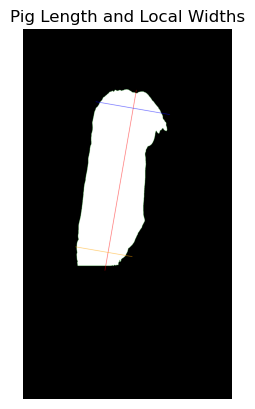

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Find largest contour
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
pig_contour = max(contours, key=cv2.contourArea)
points = pig_contour.reshape(-1, 2).astype(np.float32)

# PCA
mean, eigenvectors = cv2.PCACompute(points, mean=np.array([]))
center = mean[0]
axis = eigenvectors[0] / np.linalg.norm(eigenvectors[0])  # main axis
axis2 = eigenvectors[1] / np.linalg.norm(eigenvectors[1])  # perpendicular axis

# Project points onto main axis to get endpoints
proj = (points - center) @ axis
min_proj = proj.min()
max_proj = proj.max()
p1 = center + axis * min_proj
p2 = center + axis * max_proj

# Choose fraction along length for "top" and "bottom" widths
frac_shift = 0.1
top_point = p1 + (p2 - p1) * frac_shift
bottom_point = p2 - (p2 - p1) * frac_shift

def local_width(sample_point, points, axis, axis2, window_frac=0.1):
    """
    Compute width along axis2 for points near sample_point along main axis.
    window_frac: fraction of length axis to include for local width
    """
    length = np.linalg.norm(p2 - p1)
    window = length * window_frac

    # Project points on main axis
    proj_main = (points - sample_point) @ axis
    # Select points within window around sample_point
    local_pts = points[np.abs(proj_main) <= window]

    # Project local points on perpendicular axis
    proj_perp = (local_pts - sample_point) @ axis2
    min_p = proj_perp.min()
    max_p = proj_perp.max()
    p_start = sample_point + axis2 * min_p
    p_end   = sample_point + axis2 * max_p
    width = np.linalg.norm(p_end - p_start)
    return width, p_start, p_end

# Compute widths
width_top, top_a, top_b = local_width(top_point, points, axis, axis2, 0.1)
width_bottom, bot_a, bot_b = local_width(bottom_point, points, axis, axis2, 0.1)

# Length
length = np.linalg.norm(p2 - p1)
print(f"Pig length (pixels): {length:.2f}")
print(f"Width near top: {width_top:.2f}")
print(f"Width near bottom: {width_bottom:.2f}")

# Draw
mask_rgb = cv2.cvtColor(binary_mask*255, cv2.COLOR_GRAY2BGR)
cv2.drawContours(mask_rgb, [pig_contour], -1, (0,255,0), 1)
cv2.line(mask_rgb, tuple(p1.astype(int)), tuple(p2.astype(int)), (0,0,255), 2)       # length
cv2.line(mask_rgb, tuple(top_a.astype(int)), tuple(top_b.astype(int)), (255,0,0), 2)  # top width
cv2.line(mask_rgb, tuple(bot_a.astype(int)), tuple(bot_b.astype(int)), (0,165,255), 2)  # bottom width

plt.imshow(cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB))
plt.title("Pig Length and Local Widths")
plt.axis("off")
plt.show()


Annotation info:
Image size: {'height': 2647, 'width': 1520}
Number of objects: 1
Decompressed data length: 3764
Origin: [327, 84]
Bitmap shape: (1442, 787)
Bitmap unique values: [  0 255]

Final mask shape: (2647, 1520)
Final mask unique values: [  0 255]
Non-zero pixels: 706913


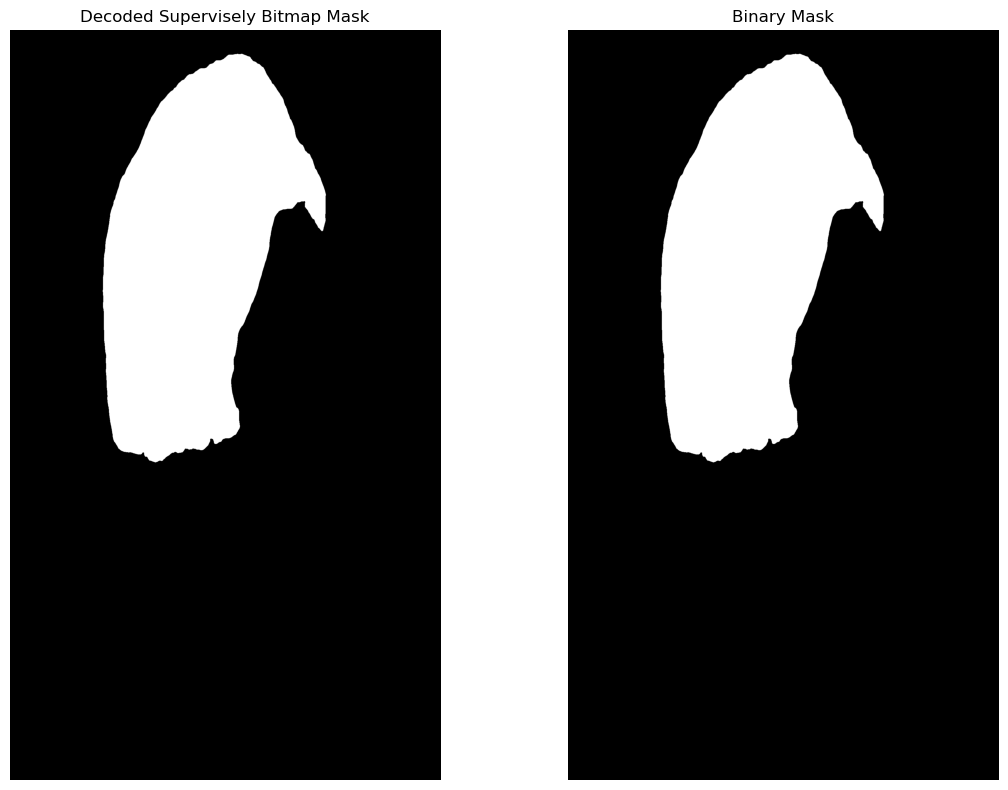

In [13]:
# Load and decode the annotation
json_path = r"supervisely/dataset/ann/IMG_0366.jpeg.json"
with open(json_path, 'r') as f:
    annotation_data = json.load(f)

print("Annotation info:")
print(f"Image size: {annotation_data['size']}")
print(f"Number of objects: {len(annotation_data.get('objects', []))}")

# Decode the bitmap mask
mask2 = decode_supervisely_bitmap_proper(annotation_data)

print(f"\nFinal mask shape: {mask2.shape}")
print(f"Final mask unique values: {np.unique(mask2)}")
print(f"Non-zero pixels: {np.sum(mask2 > 0)}")

# Visualize the mask
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(mask2, cmap='gray')
plt.title('Decoded Supervisely Bitmap Mask')
plt.axis('off')

# Show mask as binary
plt.subplot(1, 2, 2)
binary_mask2 = (mask2 > 0).astype(np.uint8)
plt.imshow(binary_mask2, cmap='gray')
plt.title('Binary Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def measure_pig_length_and_widths(binary_mask, frac_shift=0.1, window_frac=0.1, visualize=True):
    """
    Measure the pig's main body length and approximate widths near the top and bottom
    based on PCA of the largest contour in a binary mask.

    Arg:
    binary_mask : np.ndarray
        Binary image (0 or 1 / 0 or 255) containing the pig segmentation.
    frac_shift : float
        Fraction of the length along the pig to measure the top/bottom width (default 0.1 = 10%).
    window_frac : float
        Fraction of the pig's length used to compute local width window (default 0.1 = 10%).
    visualize : bool
        Whether to display the annotated image.

    Returns:
    results : dict
        {
            "length": float,
            "width_top": float,
            "width_bottom": float,
            "annotated_image": np.ndarray
        }
    """
    # Ensure binary mask is uint8
    mask = (binary_mask > 0).astype(np.uint8)

    # Find largest contour
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("No contours found in the binary mask.")
    pig_contour = max(contours, key=cv2.contourArea)
    points = pig_contour.reshape(-1, 2).astype(np.float32)

    # PCA
    mean, eigenvectors = cv2.PCACompute(points, mean=np.array([]))
    center = mean[0]
    axis = eigenvectors[0] / np.linalg.norm(eigenvectors[0])  # main axis
    axis2 = eigenvectors[1] / np.linalg.norm(eigenvectors[1])  # perpendicular axis

    # Project points onto main axis to get endpoints
    proj = (points - center) @ axis
    min_proj, max_proj = proj.min(), proj.max()
    p1 = center + axis * min_proj
    p2 = center + axis * max_proj

    # Compute top/bottom sample points
    top_point = p1 + (p2 - p1) * frac_shift
    bottom_point = p2 - (p2 - p1) * frac_shift

    def local_width(sample_point, points, axis, axis2, window_frac):
        """Compute width along axis2 near sample_point."""
        length = np.linalg.norm(p2 - p1)
        window = length * window_frac

        proj_main = (points - sample_point) @ axis
        local_pts = points[np.abs(proj_main) <= window]

        if len(local_pts) < 2:
            return 0, sample_point, sample_point

        proj_perp = (local_pts - sample_point) @ axis2
        min_p, max_p = proj_perp.min(), proj_perp.max()
        p_start = sample_point + axis2 * min_p
        p_end = sample_point + axis2 * max_p
        width = np.linalg.norm(p_end - p_start)
        return width, p_start, p_end

    # Compute widths
    width_top, top_a, top_b = local_width(top_point, points, axis, axis2, window_frac)
    width_bottom, bot_a, bot_b = local_width(bottom_point, points, axis, axis2, window_frac)

    # Compute length
    length = np.linalg.norm(p2 - p1)

    # Draw visualization
    mask_rgb = cv2.cvtColor(mask * 255, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(mask_rgb, [pig_contour], -1, (0, 255, 0), 1)
    cv2.line(mask_rgb, tuple(p1.astype(int)), tuple(p2.astype(int)), (0, 0, 255), 2)  # main length
    cv2.line(mask_rgb, tuple(top_a.astype(int)), tuple(top_b.astype(int)), (255, 0, 0), 2)  # top width
    cv2.line(mask_rgb, tuple(bot_a.astype(int)), tuple(bot_b.astype(int)), (0, 165, 255), 2)  # bottom width

    if visualize:
        plt.imshow(cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB))
        plt.title("Pig Length and Local Widths")
        plt.axis("off")
        plt.show()

    return {
        "length": length,
        "width_top": width_top,
        "width_bottom": width_bottom,
        "annotated_image": mask_rgb
    }


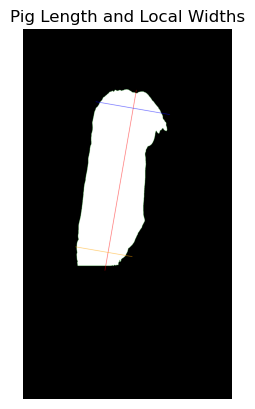

Pig length (pixels): 1438.66
Width near top: 588.73
Width near bottom: 453.20


In [17]:
results = measure_pig_length_and_widths(binary_mask)

print(f"Pig length (pixels): {results['length']:.2f}")
print(f"Width near top: {results['width_top']:.2f}")
print(f"Width near bottom: {results['width_bottom']:.2f}")


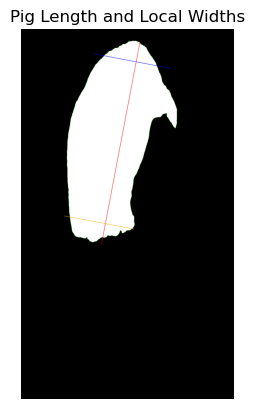

Pig length (pixels): 1473.17
Width near top: 557.78
Width near bottom: 501.79


In [ ]:
results = measure_pig_length_and_widths(binary_mask2)

print(f"Pig length (pixels): {results['length']:.2f}")
print(f"Width near top: {results['width_top']:.2f}")
print(f"Width near bottom: {results['width_bottom']:.2f}")


=== Debug: Checking actual files ===
Image files: ['aug_0_2246b75a-6673-45b7-8d50-fc68a1daba20.png', 'aug_0_3.jpg', 'aug_0_43777abf-3373-4d53-80b2-ddcd06745714.png', 'aug_0_blackpig1.png', 'aug_0_blackpig1crop.jpg', 'aug_0_IMG_0366.jpeg', 'aug_0_Whisk_734708d8200b1c59ad1499cfd5218a85dr.jpeg', 'aug_1_2246b75a-6673-45b7-8d50-fc68a1daba20.png', 'aug_1_3.jpg', 'aug_1_43777abf-3373-4d53-80b2-ddcd06745714.png', 'aug_1_blackpig1.png', 'aug_1_blackpig1crop.jpg', 'aug_1_IMG_0366.jpeg', 'aug_1_Whisk_734708d8200b1c59ad1499cfd5218a85dr.jpeg', 'aug_2_2246b75a-6673-45b7-8d50-fc68a1daba20.png', 'aug_2_3.jpg', 'aug_2_43777abf-3373-4d53-80b2-ddcd06745714.png', 'aug_2_blackpig1.png', 'aug_2_blackpig1crop.jpg', 'aug_2_IMG_0366.jpeg', 'aug_2_Whisk_734708d8200b1c59ad1499cfd5218a85dr.jpeg', 'aug_3_2246b75a-6673-45b7-8d50-fc68a1daba20.png', 'aug_3_3.jpg', 'aug_3_43777abf-3373-4d53-80b2-ddcd06745714.png', 'aug_3_blackpig1.png', 'aug_3_blackpig1crop.jpg', 'aug_3_IMG_0366.jpeg', 'aug_3_Whisk_734708d8200b1c59ad1

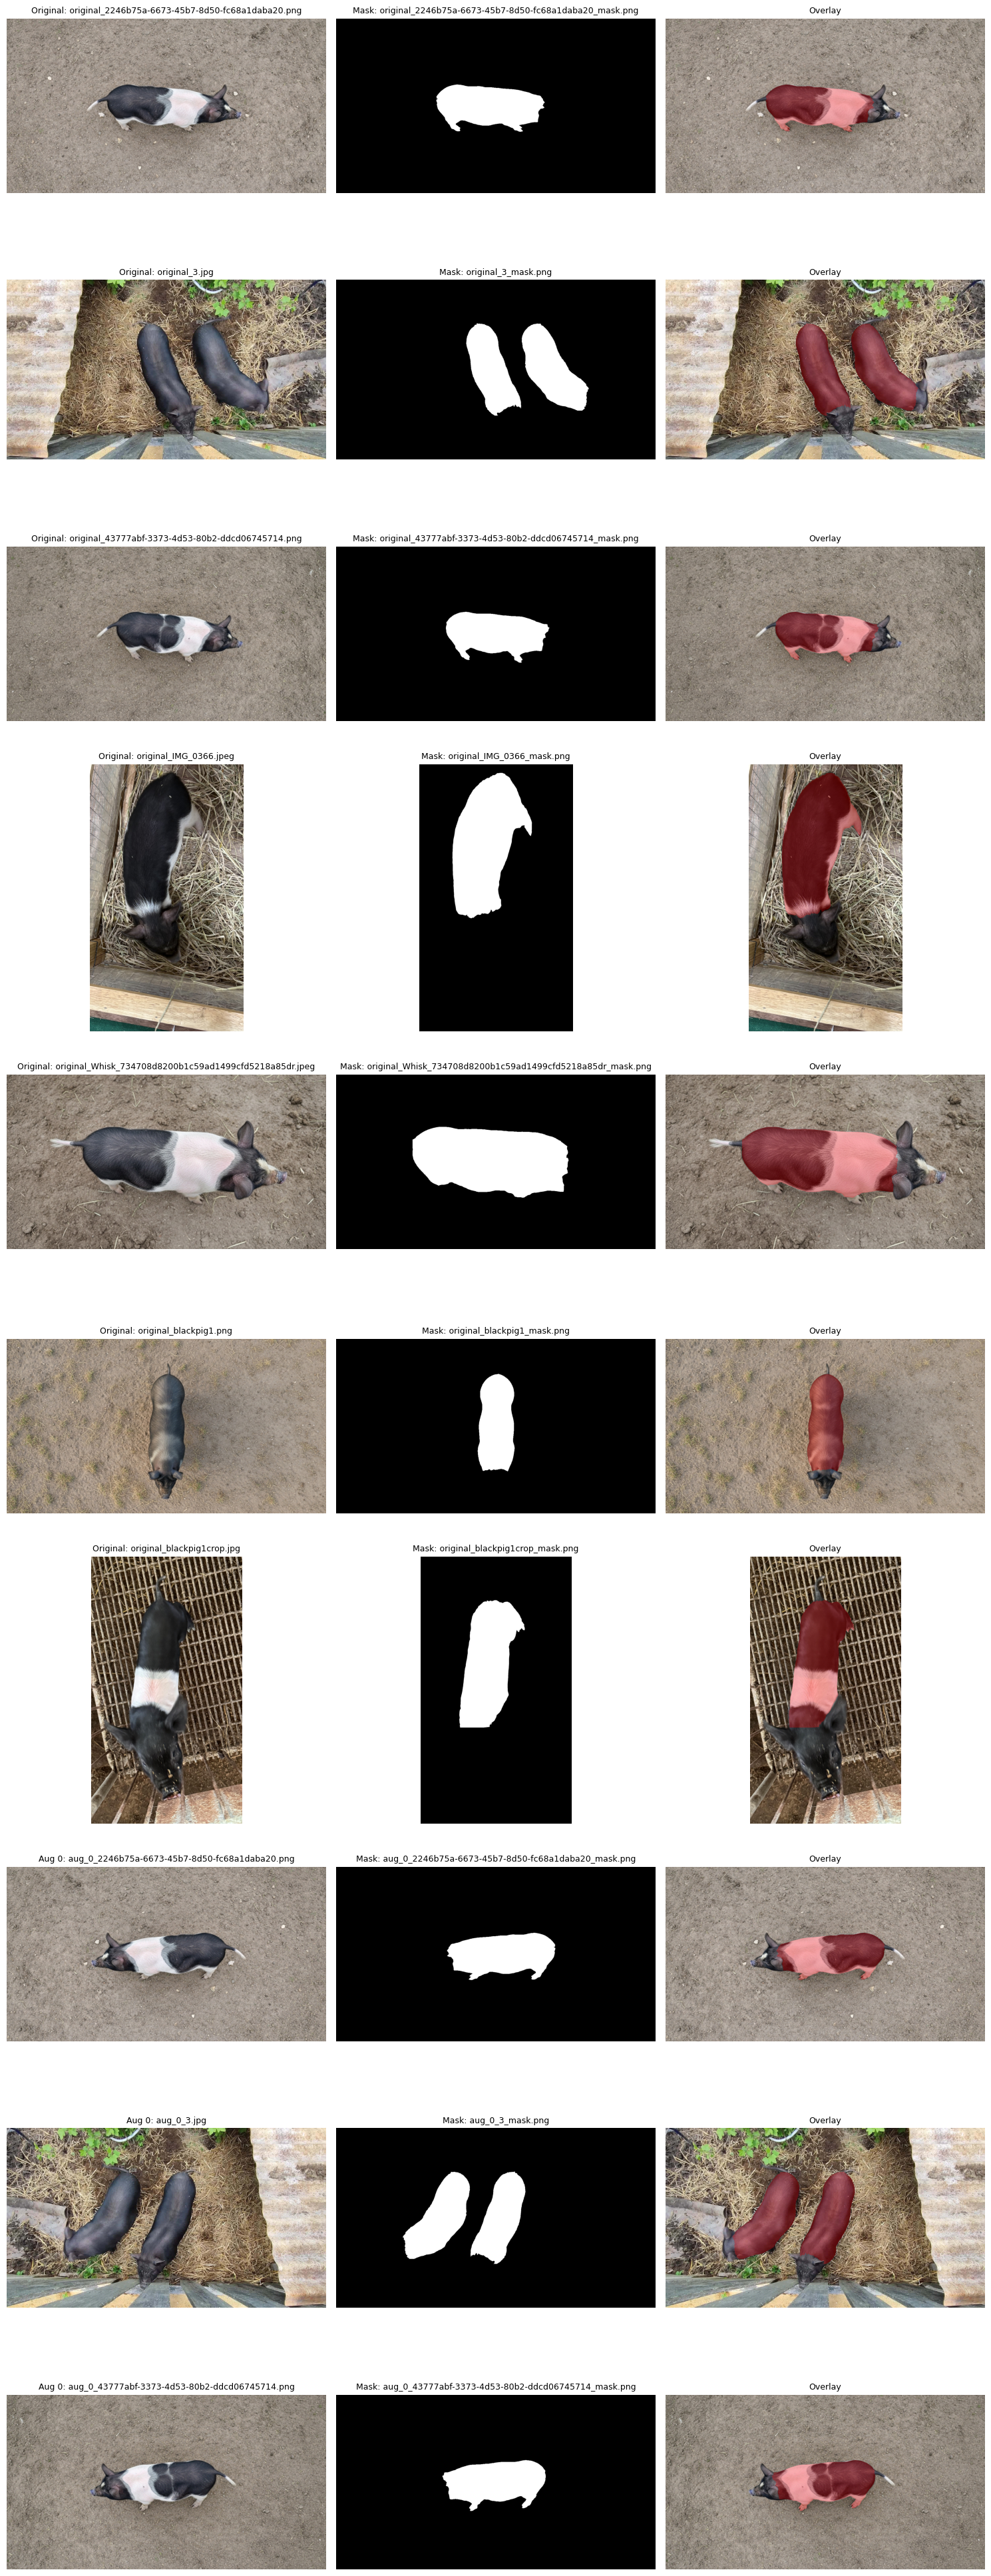


=== Comparison for specific image ===
Found 5 complete versions of blackpig1crop.jpg


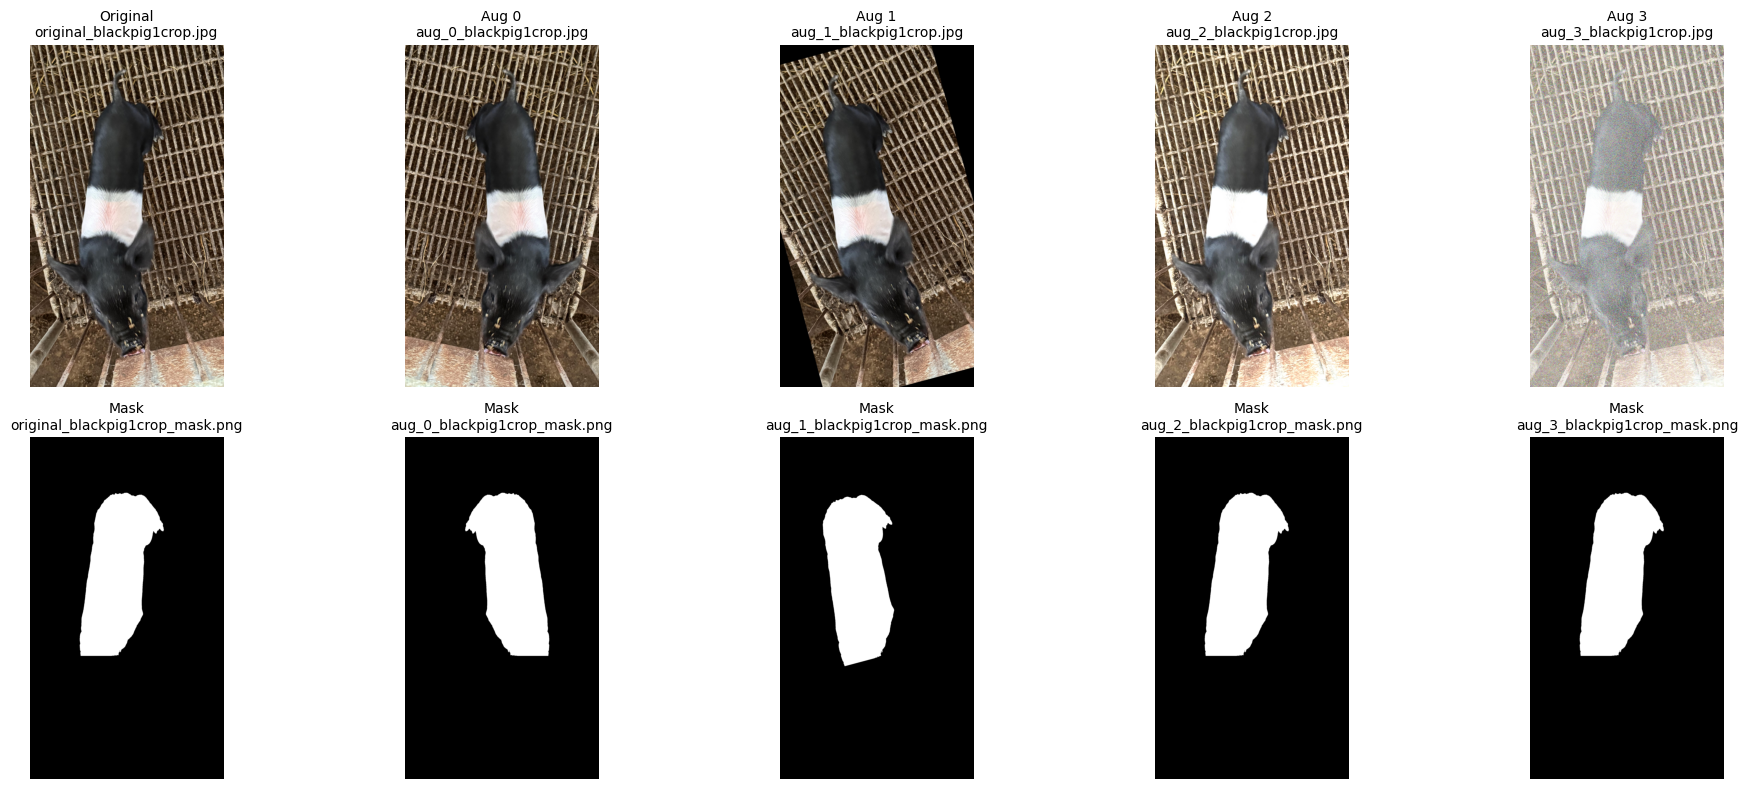

Found 5 complete versions of 3.jpg


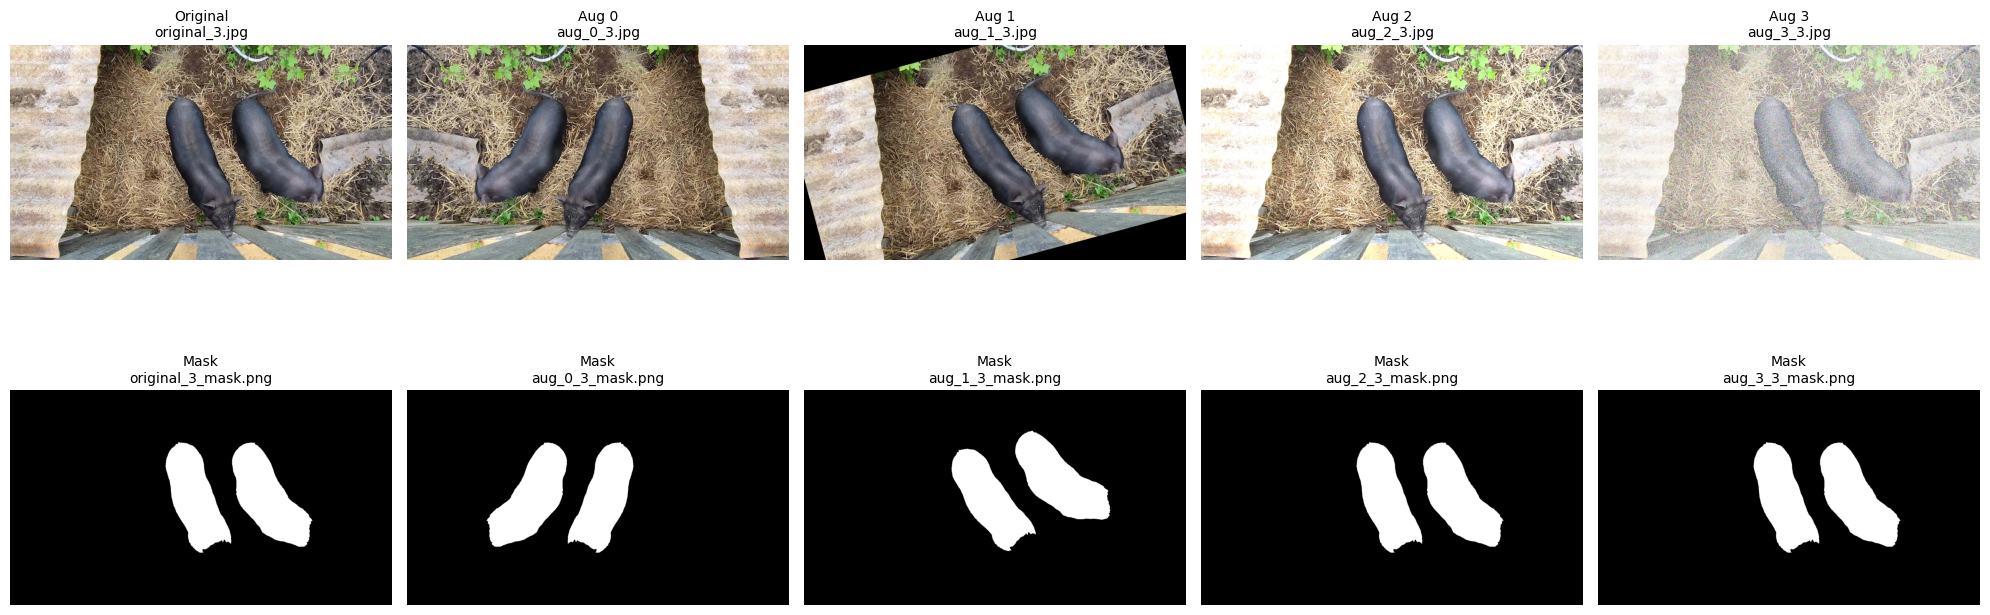

In [21]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def display_augmented_dataset(augmented_dataset_path, max_display=5):
    """
    Display augmented images along with their corresponding masks
    """
    img_dir = os.path.join(augmented_dataset_path, "img")
    mask_dir = os.path.join(augmented_dataset_path, "masks")
    
    # Check if directories exist
    if not os.path.exists(img_dir):
        print(f"Image directory does not exist: {img_dir}")
        return
    
    if not os.path.exists(mask_dir):
        print(f"Mask directory does not exist: {mask_dir}")
        return
    
    # Get all image files
    img_files = [f for f in os.listdir(img_dir) 
                 if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
    
    # Get all mask files
    mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.png')]
    
    print(f"Found {len(img_files)} augmented images and {len(mask_files)} masks")
    print(f"Sample image files: {img_files[:3]}")
    print(f"Sample mask files: {mask_files[:3]}")
    
    # Create pairs directly by matching prefixes and base names
    matched_pairs = []
    
    for img_file in img_files:
        # Extract prefix and base name from image file
        if img_file.startswith('original_'):
            prefix = 'original'
            base_name = img_file[9:]  # Remove "original_"
        elif img_file.startswith('aug_'):
            # Extract aug number
            parts = img_file.split('_', 2)
            if len(parts) >= 3:
                prefix = f"aug_{parts[1]}"
                base_name = '_'.join(parts[2:])
            else:
                continue
        else:
            continue
        
        # Look for corresponding mask - use base name WITHOUT extension
        base_name_no_ext = os.path.splitext(base_name)[0]
        expected_mask = f"{prefix}_{base_name_no_ext}_mask.png"
        
        if expected_mask in mask_files:
            matched_pairs.append({
                'prefix': prefix,
                'image': img_file,
                'mask': expected_mask,
                'base_name': base_name
            })
            print(f"Matched: {img_file} -> {expected_mask}")
        else:
            print(f"No mask found for {img_file}, expected: {expected_mask}")
    
    print(f"Found {len(matched_pairs)} complete image-mask pairs")
    
    # Sort pairs: original first, then augmentations
    matched_pairs.sort(key=lambda x: (
        0 if x['prefix'] == 'original' else 1,  # Original first
        int(x['prefix'].split('_')[1]) if x['prefix'].startswith('aug_') else 0,  # Then by aug number
        x['base_name']  # Then by base name
    ))
    
    # Limit display
    if len(matched_pairs) > max_display:
        print(f"Limiting display to first {max_display} pairs")
        matched_pairs = matched_pairs[:max_display]
    
    if not matched_pairs:
        print("No complete image-mask pairs found!")
        return
    
    # Create subplots (3 columns: image, mask, overlay)
    cols = 3
    rows = len(matched_pairs)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
    
    # Handle single row case
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, pair in enumerate(matched_pairs):
        try:
            # Load image
            img_path = os.path.join(img_dir, pair['image'])
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Load mask
            mask_path = os.path.join(mask_dir, pair['mask'])
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask_binary = (mask > 127).astype(np.uint8)
            
            # Resize mask to match image if needed
            if mask.shape[:2] != image.shape[:2]:
                mask_binary = cv2.resize(mask_binary, (image.shape[1], image.shape[0]), 
                                       interpolation=cv2.INTER_NEAREST)
            
            # Create overlay
            overlay = image.copy()
            overlay[mask_binary > 0] = overlay[mask_binary > 0] * 0.7 + np.array([255, 0, 0]) * 0.3
            
            # Determine title
            if pair['prefix'] == 'original':
                title_prefix = "Original"
            else:
                aug_num = pair['prefix'].split('_')[1]
                title_prefix = f"Aug {aug_num}"
            
            # Display image
            axes[i, 0].imshow(image)
            axes[i, 0].set_title(f'{title_prefix}: {pair["image"]}', fontsize=9)
            axes[i, 0].axis('off')
            
            # Display mask
            axes[i, 1].imshow(mask_binary, cmap='gray')
            axes[i, 1].set_title(f'Mask: {pair["mask"]}', fontsize=9)
            axes[i, 1].axis('off')
            
            # Display overlay
            axes[i, 2].imshow(overlay)
            axes[i, 2].set_title('Overlay', fontsize=9)
            axes[i, 2].axis('off')
            
            print(f"Displayed: {pair['prefix']} - {pair['base_name']}")
            
        except Exception as e:
            print(f"Error processing {pair['image']}: {e}")
            
            # Display error message in plots
            for j in range(3):
                axes[i, j].text(0.5, 0.5, f'Error loading\n{pair["image"]}', 
                              ha='center', va='center', transform=axes[i, j].transAxes)
                axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return matched_pairs

def display_augmented_comparison(augmented_dataset_path, base_image_name, max_augs=5):
    """
    Display original image and its augmentations side by side
    """
    img_dir = os.path.join(augmented_dataset_path, "img")
    mask_dir = os.path.join(augmented_dataset_path, "masks")
    
    # Find all files related to the base image
    related_files = []
    base_name_no_ext = os.path.splitext(base_image_name)[0]
    
    # Find original
    original_img = f"original_{base_image_name}"
    original_mask = f"original_{base_name_no_ext}_mask.png"
    
    if os.path.exists(os.path.join(img_dir, original_img)):
        if os.path.exists(os.path.join(mask_dir, original_mask)):
            related_files.append(('Original', original_img, original_mask))
        else:
            print(f"Original mask not found: {original_mask}")
    
    # Find augmentations
    for i in range(max_augs):
        aug_img = f"aug_{i}_{base_image_name}"
        aug_mask = f"aug_{i}_{base_name_no_ext}_mask.png"
        
        if os.path.exists(os.path.join(img_dir, aug_img)):
            if os.path.exists(os.path.join(mask_dir, aug_mask)):
                related_files.append((f'Aug {i}', aug_img, aug_mask))
            else:
                print(f"Aug {i} mask not found: {aug_mask}")
    
    if not related_files:
        print(f"No complete files found for base image: {base_image_name}")
        return
    
    print(f"Found {len(related_files)} complete versions of {base_image_name}")
    
    # Create subplots
    cols = len(related_files)
    rows = 2  # Image and mask
    
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 8))
    
    # Handle single column case
    if cols == 1:
        axes = axes.reshape(-1, 1)
    
    for i, (label, img_file, mask_file) in enumerate(related_files):
        try:
            # Load image
            img_path = os.path.join(img_dir, img_file)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Load mask
            mask_path = os.path.join(mask_dir, mask_file)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask_binary = (mask > 127).astype(np.uint8)
            
            # Display image
            axes[0, i].imshow(image)
            axes[0, i].set_title(f'{label}\n{img_file}', fontsize=10)
            axes[0, i].axis('off')
            
            # Display mask
            axes[1, i].imshow(mask_binary, cmap='gray')
            axes[1, i].set_title(f'Mask\n{mask_file}', fontsize=10)
            axes[1, i].axis('off')
            
        except Exception as e:
            print(f"Error processing {label}: {e}")
            axes[0, i].text(0.5, 0.5, f'Error\n{label}', ha='center', va='center', 
                           transform=axes[0, i].transAxes)
            axes[1, i].text(0.5, 0.5, f'Error\n{label}', ha='center', va='center', 
                           transform=axes[1, i].transAxes)
            axes[0, i].axis('off')
            axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Debug: First, let's see what files actually exist
augmented_dataset_path = "supervisely/augmented_dataset"
img_dir = os.path.join(augmented_dataset_path, "img")
mask_dir = os.path.join(augmented_dataset_path, "masks")

print("=== Debug: Checking actual files ===")
if os.path.exists(img_dir):
    img_files = os.listdir(img_dir)
    print(f"Image files: {img_files}")
else:
    print("Image directory doesn't exist")

if os.path.exists(mask_dir):
    mask_files = os.listdir(mask_dir)
    print(f"Mask files: {mask_files}")
else:
    print("Mask directory doesn't exist")

print("\n=== All Augmented Images ===")
display_augmented_dataset(augmented_dataset_path, max_display=10)

print("\n=== Comparison for specific image ===")
display_augmented_comparison(augmented_dataset_path, "blackpig1crop.jpg", max_augs=4)
display_augmented_comparison(augmented_dataset_path, "3.jpg", max_augs=4)